In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s
import test

import time

In [2]:
DATA_PATH = "data/test/"
SAVE_PATH = DATA_PATH + "generated_data/"

# Create Dataset (positions and velocities)

In [3]:
nb = 50
trajectories,velocities,nb_trajectories = test.create_dataset(nb)

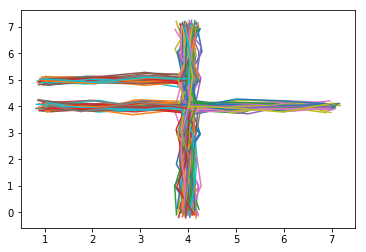

In [4]:
ut.refactor_and_plot(trajectories)

## Compute the others trajectories features

### Separate features between train and test set

In [17]:
test_prop = 0.2
ids_train, ids_test, [X_train_trajectories, X_train_velocities], _ = test.split_train_test(nb_trajectories,[trajectories,velocities], test_prop)

In [18]:
X_train_features = np.array([ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_train_trajectories,X_train_velocities)])

### Standardize and apply pca on training set

In [19]:
X_train_features_std_pca,train_features_stder, pca_train_clust_traj = test.standardize_and_reduce_dimensions(X_train_features)

nb_components: 20


### Search for the optimal number of clusters

optimal numbers of clusters: [4, 8, 12]


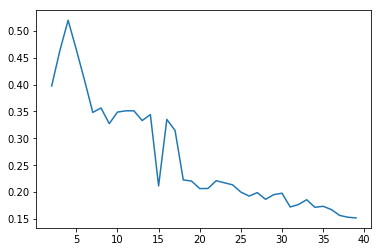

In [20]:
max_clusters = int((1-test_prop) * nb)
nb_clusters = test.get_optimal_cluster_number(max_clusters,X_train_features_std_pca,KMeans(),True)

#### PLot clusters

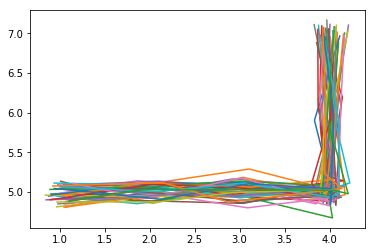

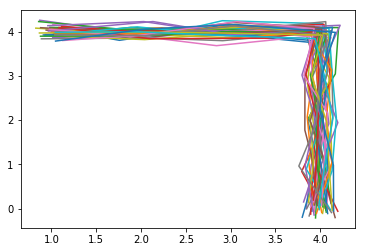

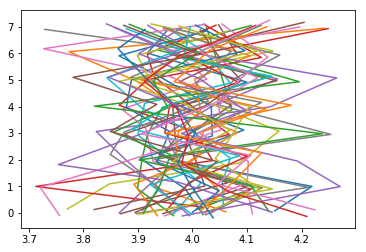

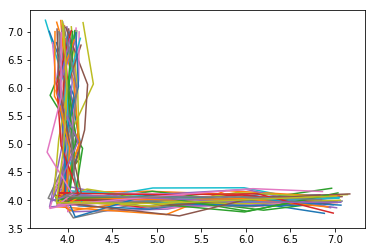

In [21]:
X_train_targets = test.plot_clusters(nb_clusters,KMeans(),X_train_features_std_pca,X_train_trajectories)

### CLustering on starting points to learn the different categories of starting points

In [22]:
points_data,points,nb_points = test.get_first_points_data(X_train_trajectories, X_train_velocities )

#### Apply standardization and PCA for starting points clustering

In [23]:
points_data_std_pca,scaler_points,pca_points = test.standardize_and_reduce_dimensions(points_data)

nb_components: 2


optimal numbers of clusters: [3, 23, 26]


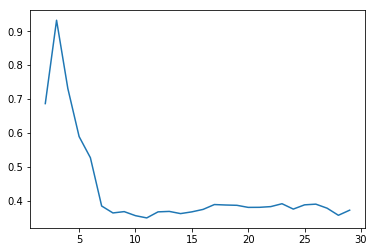

In [24]:
max_clusters = 30
nb_clusters = test.get_optimal_cluster_number(max_clusters,points_data_std_pca,KMeans(),True)

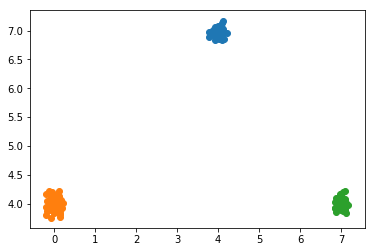

In [25]:
point_targets = test.plot_points_clusters(nb_clusters,KMeans(),points_data_std_pca,points)

### Train point classifier

#### Get train and test sets

In [26]:
point_test_prop = 0.20
ids_train, ids_test, [points_data_train,point_targets_train], [points_data_test,point_targets_test ] = test.split_train_test(nb_points,[points_data,point_targets], point_test_prop)

#### get standardization and pca from  training set

In [27]:
points_data_train_std_pca,scaler_point_class,pca_point_class = test.standardize_and_reduce_dimensions(points_data_train)

nb_components: 2


Then apply them on the test set

In [30]:
points_data_test_std = scaler_point_class.transform(points_data_test)
points_data_test_std_pca = pca_point_class.transform(points_data_test_std)

##### Train point classifier

In [31]:
point_classifier = LogisticRegression(multi_class = "multinomial", solver = "newton-cg")
point_classifier.fit(points_data_train_std_pca,point_targets_train)
train_point_pred = point_classifier.predict(points_data_train_std_pca)
test_point_pred = point_classifier.predict(points_data_test_std_pca)

###### Performance results

In [32]:
print("train error: " + str(f1_score(point_targets_train,train_point_pred,average = "micro")))
print("test error: " + str(f1_score(point_targets_test,test_point_pred,average = "micro")))

train error: 1.0
test error: 1.0


##### retrain classifier on the whole dataset

In [33]:
points_data_std = scaler_point_class.fit_transform(points_data)
points_data_std_pca = pca_point_class.fit_transform(points_data_std)
point_classifier.fit(points_data_std_pca,point_targets)
point_pred = point_classifier.predict(points_data_std_pca)

# Train partial trajectory classifier

To learn how to classify a subtrajectory, the features will be the starting point class (as a binary representation) and stats on the subtrajectory

## Random subtrajectories extraction

For each trajectory in the training set, for a defined number of sub trajectory per trajectory, we pick a subtrajectory whose size is randomly pick between 3 and the minimum trajectory length of the trajectory

In [35]:
X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets = test.extract_subtrajectories(X_train_trajectories,X_train_velocities,X_train_targets,point_targets,10,3)

### Get train and test set for trajectory classification

In [36]:
to_split = [X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets]

ids_train, ids_test, trains, tests = test.split_train_test(nb_points,to_split, point_test_prop)

[X_train_sub_trajectories,X_train_sub_velocities,X_train_sub_targets,X_train_sub_point_targets] = trains
[X_test_sub_trajectories,X_test_sub_velocities,X_test_sub_targets,X_test_sub_point_targets] = tests

### Compute features and normalize

In [37]:
X_train_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_train_sub_trajectories,X_train_sub_velocities)]
X_train_sub_features_std,trajectory_train_stder = ft.standardize_features(X_train_sub_features)
X_train_sub_features_std = pd.DataFrame(X_train_sub_features_std)

##### use the same standardizer fit with train for test

In [34]:
X_test_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_test_sub_trajectories,X_test_sub_velocities)]
X_test_sub_features_std,_ = ft.standardize_features(X_test_sub_features,trajectory_train_stder)
X_test_sub_features_std = pd.DataFrame(X_test_sub_features_std)

### one hot encode the subtrajectory starting point class

In [35]:
ohe_train_trajectory = OneHotEncoder(sparse = False, dtype=np.int)

one_hot_train_startpoint_class = pd.DataFrame(ohe_train_trajectory.fit_transform(X_train_sub_point_targets.reshape(-1,1)))
one_hot_test_startpoint_class = pd.DataFrame(ohe_train_trajectory.transform(X_test_sub_point_targets.reshape(-1,1)))

In [36]:
X_train = pd.concat([one_hot_train_startpoint_class,X_train_sub_features_std], axis=1)
y_train = X_train_sub_targets

In [37]:
X_test = pd.concat([one_hot_test_startpoint_class,X_test_sub_features_std], axis=1)
y_test = X_test_sub_targets

#### Apply pca

In [38]:
pca_train_class_traj = PCA(n_components=0.99)
X_train_pca = pca_train_class_traj.fit_transform(X_train)
X_test_pca = pca_train_class_traj.transform(X_test)
pca_train_class_traj.n_components_

18

### Train classifier

In [39]:
subtrajectory_classifier = LogisticRegression(multi_class = "multinomial", solver = "newton-cg")
subtrajectory_classifier.fit(X_train_pca,y_train)
train_pred = subtrajectory_classifier.predict(X_train_pca)
test_pred = subtrajectory_classifier.predict(X_test_pca)

#### classification performances

In [40]:
print("train error: " + str(f1_score(X_train_sub_targets,train_pred,average = "micro")))
print("test error: " + str(f1_score(X_test_sub_targets,test_pred,average = "micro")))

train error: 1.0
test error: 1.0


#### retrain on the whole dataset

In [41]:
ohe_trajectory = OneHotEncoder(sparse = False, dtype=np.int)
one_hot_startpoint_class = pd.DataFrame(ohe_trajectory.fit_transform(X_sub_point_targets.reshape(-1,1)))

X_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_sub_trajectories,X_sub_velocities)]
X_sub_features_std,trajectory_stder = ft.standardize_features(X_sub_features)
X_sub_features_std = pd.DataFrame(X_sub_features_std)

X = pd.concat([one_hot_startpoint_class,X_sub_features_std], axis=1)
y = X_sub_targets

pca_class_traj = PCA(n_components=0.99)
X_pca = pca_class_traj.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

In [42]:
subtrajectory_classifier.fit(X_pca,y)
trajectories_pred = subtrajectory_classifier.predict(X_pca)

# Apply on unseen trajectories

In [43]:
X_test_trajectories = trajectories[ids_test]
X_test_velocities = velocities[ids_test]

In [44]:
X_test_features = np.array([ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_test_trajectories,X_test_velocities)])

In [45]:
#X_test_features_std,_ = ft.standardize_features(X_test_features,trajectory_stder)
#X_test_features_std = pd.DataFrame(X_test_features_std)

In [46]:
#X_test_features_std_pca = pca_class_traj.transform(X_test_features_std)

In [47]:
trajectory = X_test_trajectories[0]
velocity = X_test_velocities[0]

In [48]:
np.random.seed(10)
nb_points = np.random.randint(1,len(trajectory) + 1)

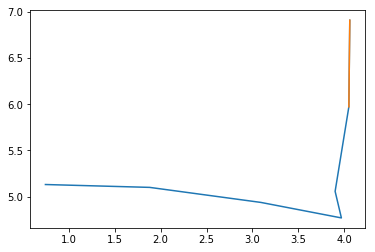

In [49]:
ut.refactor_and_plot([trajectory,trajectory[:nb_points]])

In [50]:
sub_trajectory = trajectory[:nb_points]
sub_velocity= velocity[:nb_points]
starting_point = sub_trajectory[0]
sub_rots = ft.compute_ROTS(sub_trajectory)

In [51]:
sub_features = ft.compute_features(sub_trajectory,sub_velocity)

In [52]:
sub_features_std = ft.standardize_features([sub_features],trajectory_stder)

In [53]:
p_data = pd.DataFrame([starting_point[0],starting_point[1],sub_velocity[0],sub_rots[0]]).T
p_data = p_data.values
p_data_std = scaler_point_class.transform(p_data)
p_data_std_pca = pca_point_class.transform(p_data_std)
point_class = point_classifier.predict(p_data_std_pca)
ohe_point_class = ohe_trajectory.transform(point_class.reshape(1,-1))
#point_class = 

In [54]:
f = pd.DataFrame(sub_features_std[0])
pc = pd.DataFrame(ohe_point_class)
x = pd.concat([pc,f],axis = 1)

In [55]:
x_pca = pca_class_traj.transform(x)

In [56]:
predicted_trajectory_class = subtrajectory_classifier.predict(x_pca)

In [57]:
predicted_trajectory_class

array([3], dtype=int32)